In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from helper_functions import *

# SPZ Mini Challenge 1 
### Data
For this Challenge, we used the Data of [SwissGrid](www.swissgrid.ch), which can be found here: [Energie Übersicht](https://www.swissgrid.ch/en/home/operation/grid-data/transmission.html). 

Of this Data, we use the 15 min resolution because it is the only resolution which has all the information we need. To save time on computing, the data will be upsampled to a 4-hour resolution. For certain tasks, we will use a daily resolution or a montly resolution.

### Budget, Usage and Balance
To generate those features, we do the following:
#### Budget

Addition of `"Summe produzierte Energie Regelblock Schweiz"` and `"Import"`
#### Usage

Addition of `"Summe endverbrauchte Energie Regelblock Schweiz"` and `"Export"`
#### Balance

Subtraction of `"Budget"` - `"Usage"`

## Data Loading and Data Cleaning
In the next couple of steps, we will clean the headers, fix types of certain columns, sample the data and generate the new features.

In [3]:
# Read in Data:
data = load_data('EnergieUebersichtCH-*', 'Zeitreihen0h15')
data.head()

,Unnamed: 0,Summe endverbrauchte Energie Regelblock Schweiz\nTotal energy consumed by end users in the Swiss controlblock,Summe produzierte Energie Regelblock Schweiz\nTotal energy production Swiss controlblock,Summe verbrauchte Energie Regelblock Schweiz\nTotal energy consumption Swiss controlblock,Netto Ausspeisung aus dem Übertragungsnetz Schweiz\nNet outflow of the Swiss transmission grid,Vertikale Einspeisung ins Übertragungsnetz Schweiz\nGrid feed-in Swiss transmission grid,Positive Sekundär-Regelenergie\nPositive secundary control energy,Negative Sekundär-Regelenergie\nNegative secundary control energy,Positive Tertiär-Regelenergie\nPositive tertiary control energy,Negative Tertiär-Regelenergie\nNegative tertiary control energy,...,"Produktion Kantone OW, NW, UR\nProduction Cantons OW, NW, UR","Verbrauch Kantone OW, NW, UR\nConsumption Cantons OW, NW, UR","Produktion Kantone GE, VD\nProduction Cantons GE, VD","Verbrauch Kantone GE, VD\nConsumption Cantons GE, VD","Produktion Kantone SH, ZH\nProduction Cantons SH, ZH","Verbrauch Kantone SH, ZH\nConsumption Cantons SH, ZH",Produktion Kantonsübergreifend\nProduction across Cantons,Verbrauch Kantonsübergreifend\nConsumption across Cantons,Produktion Regelzone CH - Ausländische Gebiete\nProduction control area CH - foreign territories,Verbrauch Regelzone CH - Ausländische Gebiete\nConsumption control area CH - foreign territories
0,Zeitstempel,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,kWh,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01 00:15:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01 00:30:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01 00:45:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01 01:00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Clean Dataframe (Rename columns etc.)
data_clean = data_cleaning(data.copy())
data_clean.head()

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Positive Sekundär-Regelenergie,Negative Sekundär-Regelenergie,Positive Tertiär-Regelenergie,Negative Tertiär-Regelenergie,Verbundaustausch CH->AT,...,"Produktion Kantone OW, NW, UR","Verbrauch Kantone OW, NW, UR","Produktion Kantone GE, VD","Verbrauch Kantone GE, VD","Produktion Kantone SH, ZH","Verbrauch Kantone SH, ZH",Produktion Kantonsübergreifend,Verbrauch Kantonsübergreifend,Produktion Regelzone CH - Ausländische Gebiete,Verbrauch Regelzone CH - Ausländische Gebiete
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:15:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:30:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:45:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 01:00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 01:15:00,1722372.541,1350111.973,1919922.64075,501786.775,1065655.805,0,-24000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Change from CET to UTC:
data_clean_loc = localize_time(data_clean.copy())
data_clean_loc.head()

,Summe endverbrauchte Energie Regelblock Schweiz,Summe produzierte Energie Regelblock Schweiz,Summe verbrauchte Energie Regelblock Schweiz,Netto Ausspeisung aus dem Übertragungsnetz Schweiz,Vertikale Einspeisung ins Übertragungsnetz Schweiz,Positive Sekundär-Regelenergie,Negative Sekundär-Regelenergie,Positive Tertiär-Regelenergie,Negative Tertiär-Regelenergie,Verbundaustausch CH->AT,...,"Produktion Kantone OW, NW, UR","Verbrauch Kantone OW, NW, UR","Produktion Kantone GE, VD","Verbrauch Kantone GE, VD","Produktion Kantone SH, ZH","Verbrauch Kantone SH, ZH",Produktion Kantonsübergreifend,Verbrauch Kantonsübergreifend,Produktion Regelzone CH - Ausländische Gebiete,Verbrauch Regelzone CH - Ausländische Gebiete
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2008-12-31 23:15:00+00:00,1829965.532,1328840.011,1923497.62025,535032.369,1051663.768,0,-42000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-31 23:30:00+00:00,1715172.867,1310517.237,1905593.89825,531262.971,1030932.571,0,-64000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-31 23:45:00+00:00,1732581.748,1330421.997,1919726.30525,531174.589,1054606.836,0,-52000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:00:00+00:00,1706689.208,1303333.914,1891833.42625,534226.167,1036944.249,0,-51000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-01 00:15:00+00:00,1722372.541,1350111.973,1919922.64075,501786.775,1065655.805,0,-24000,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_selected = create_features(data_clean_loc, type_='normal')
data_selected

,Strombilanz Schweiz,Strombudget Schweiz,Stromverbrauch Schweiz
Zeitstempel,,,
2008-12-31 23:15:00+00:00,85324.479,2499290.011,2413965.532
2008-12-31 23:30:00+00:00,185394.37,2454567.237,2269172.867
2008-12-31 23:45:00+00:00,200990.249,2496571.997,2295581.748
2009-01-01 00:00:00+00:00,192894.706,2463583.914,2270689.208
2009-01-01 00:15:00+00:00,199339.432,2522711.973,2323372.541
...,...,...,...
2020-12-31 22:00:00+00:00,223057.035,2614793.333,2391736.298
2020-12-31 22:15:00+00:00,176364.238,2554526.509,2378162.271
2020-12-31 22:30:00+00:00,182054.51,2507860.154,2325805.644


In [8]:
# For Faster Processing use 4 hour data:
data_m = data_selected.resample('M').mean()
data_4h = data_selected.resample('4h').mean()
data_d = data_selected.resample('1D').mean()

### EDA of Data
#### Monthly
##### Line Plots

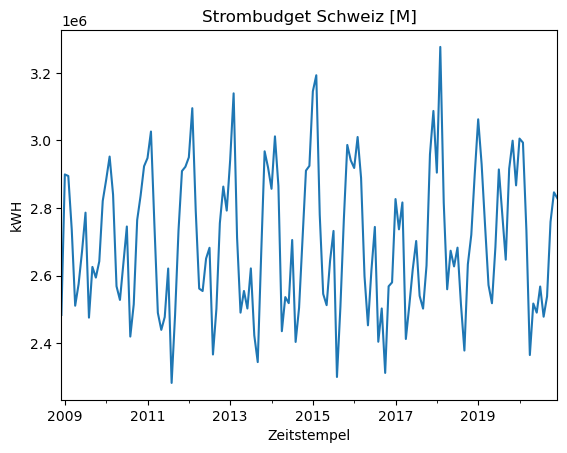

In [9]:
data_m['Strombudget Schweiz'].plot.line(ylabel='kWH', title='Strombudget Schweiz [M]')
plt.show()

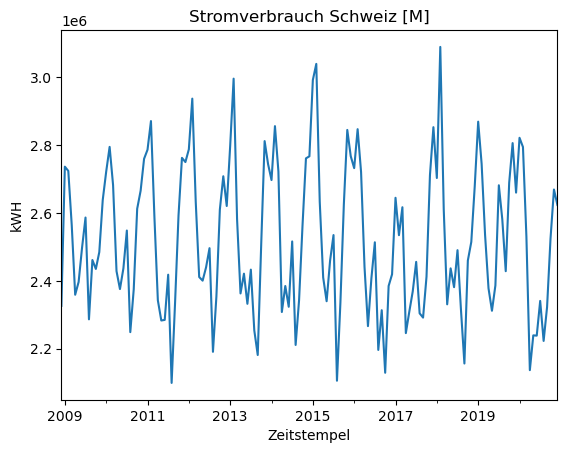

In [9]:
data_m['Stromverbrauch Schweiz'].plot.line(ylabel='kWH', title='Stromverbrauch Schweiz [M]')
plt.show()

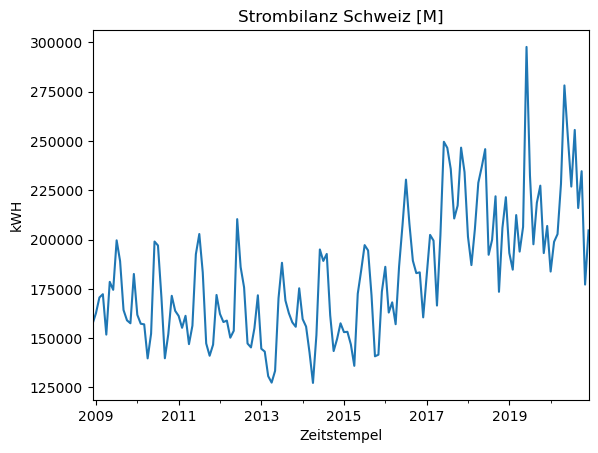

In [10]:
data_m['Strombilanz Schweiz'].plot.line(ylabel='kWH', title='Strombilanz Schweiz [M]')
plt.show()

##### Autocorrelation
We first would like to look at the yearly seasonality. This is done easiest with the a monthly resolution.

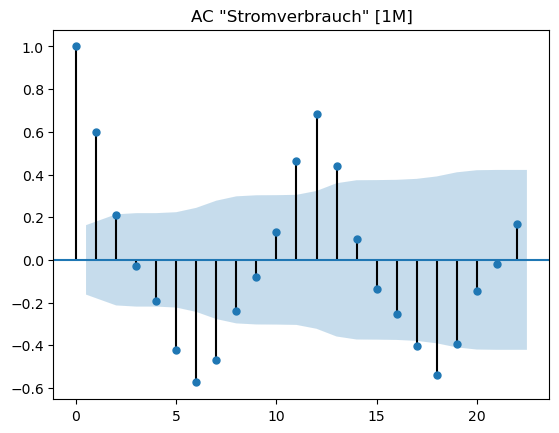

In [11]:
plot_acf(data_m['Stromverbrauch Schweiz'], title='AC "Stromverbrauch" [1M]')
plt.show()

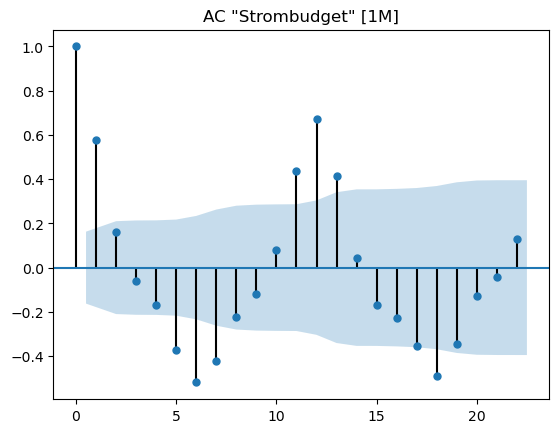

In [12]:
plot_acf(data_m['Strombudget Schweiz'], title='AC "Strombudget" [1M]')
plt.show()

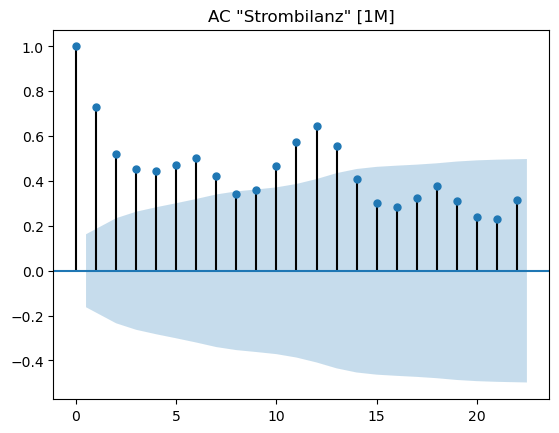

In [13]:
plot_acf(data_m['Strombilanz Schweiz'], title='AC "Strombilanz" [1M]')
plt.show()

As expected, we see a yearly seasonality in the budget and usage of electricity. Interestingly, the Balance also seems to follow a yearly cycle. We can see that they all have a peak at the lag of around 12, which is a year in months.

#### 4 Hour Data
For the 4 Hour Data, we will look more into the daily seasonality, thus only at a sub-sample at a time of the overall data.

In [14]:
ROWS_TO_PLOT = 20

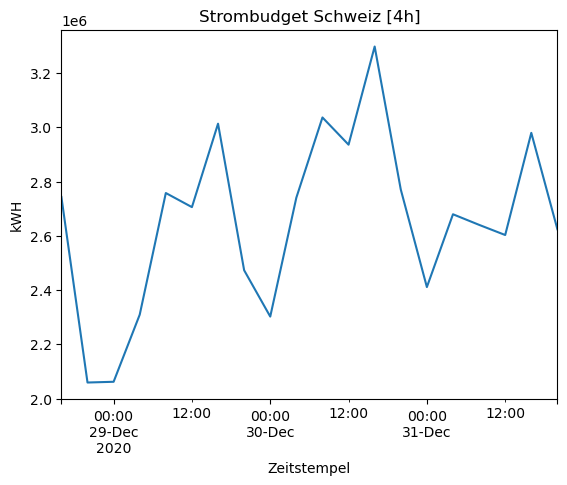

In [15]:
data_4h['Strombudget Schweiz'].tail(ROWS_TO_PLOT).plot.line(ylabel='kWH', title='Strombudget Schweiz [4h]')
plt.show()

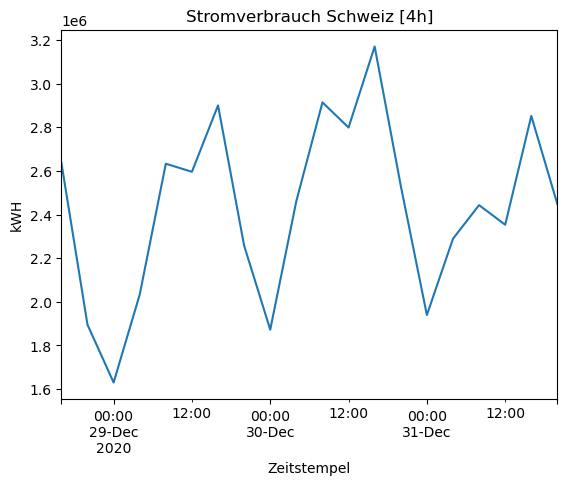

In [16]:
data_4h['Stromverbrauch Schweiz'].tail(ROWS_TO_PLOT).plot.line(ylabel='kWH', title='Stromverbrauch Schweiz [4h]')
plt.show()

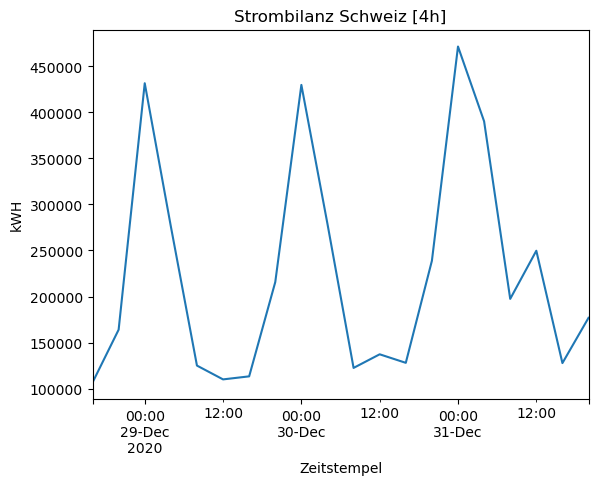

In [17]:
data_4h['Strombilanz Schweiz'].tail(ROWS_TO_PLOT).plot.line(ylabel='kWH', title='Strombilanz Schweiz [4h]')
plt.show()

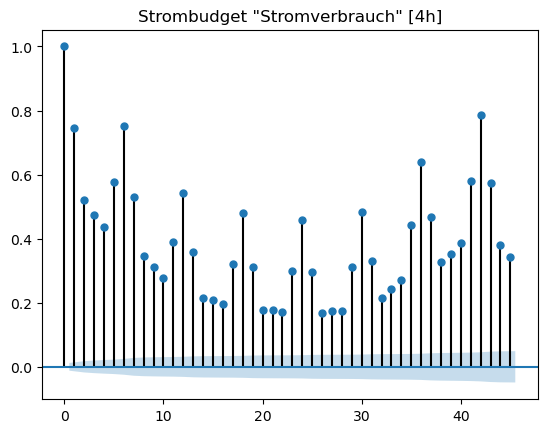

In [18]:
plot_acf(data_4h['Strombudget Schweiz'], title='Strombudget "Stromverbrauch" [4h]')
plt.show()

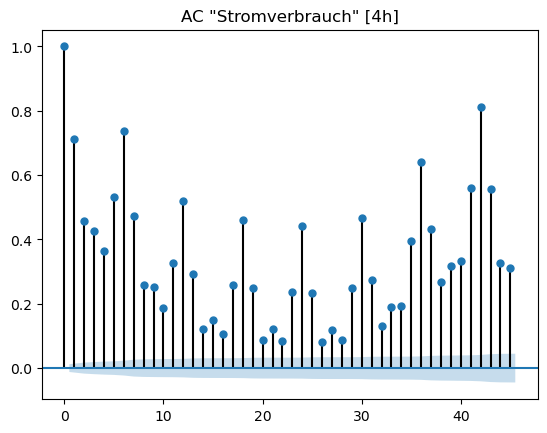

In [19]:
plot_acf(data_4h['Stromverbrauch Schweiz'], title='AC "Stromverbrauch" [4h]')
plt.show()

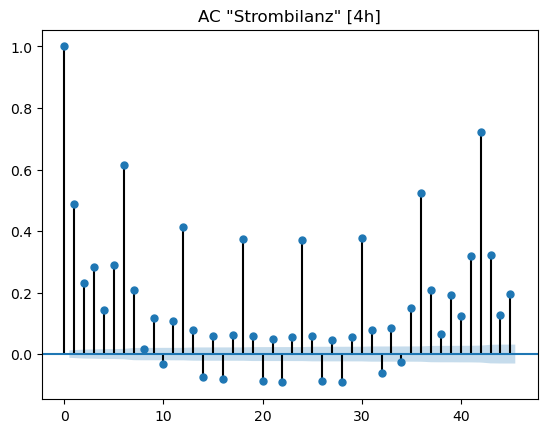

In [20]:
plot_acf(data_4h['Strombilanz Schweiz'], title='AC "Strombilanz" [4h]')
plt.show()

As expected, we see a daily trend because the lag peaks at an intervall of 6. 6*4 = 24 = 1 Day. As seen in the line plots above, the "Strombilanz" clearly shows a strong spike at 00:00 each day. 

#### Hourly data averaged over multiple years
Above we only looked at a subsample. The trend should also be seeable if we take the average of the hourly data over multiple years.

In [21]:
data_4h_average = data_4h.copy()
data_4h_average['datetime'] = data_4h_average.index.strftime("%d-%m %H:%M")
data_4h_average = data_4h_average.groupby(data_4h_average.datetime).mean()

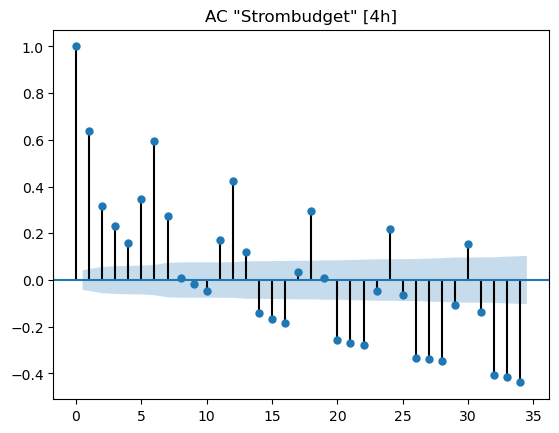

In [22]:
plot_acf(data_4h_average['Strombudget Schweiz'], title='AC "Strombudget" [4h]')
plt.show()

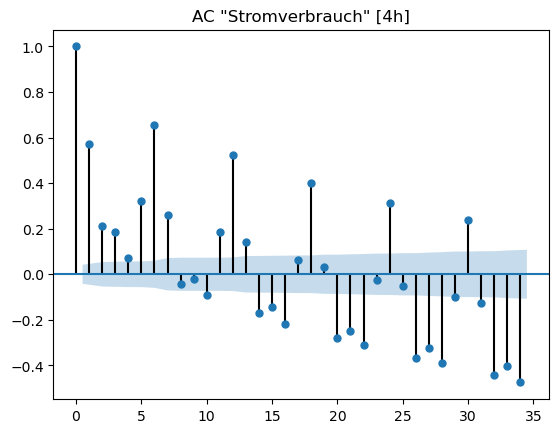

In [23]:
plot_acf(data_4h_average['Stromverbrauch Schweiz'], title='AC "Stromverbrauch" [4h]')
plt.show()

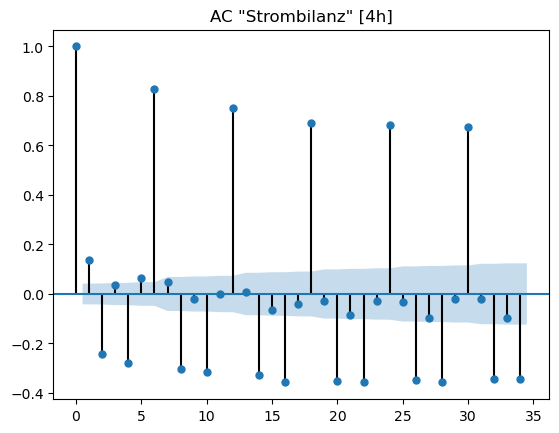

In [24]:
plot_acf(data_4h_average['Strombilanz Schweiz'], title='AC "Strombilanz" [4h]')
plt.show()

Es hat sich gelohnt, sich das auch unabhängig vom Jahr anzuschauen. Wir sehen auch hier den Lag von 6, was einem Tag entspricht.

## Sesonal decomposition
### Jährliche Seasonalität
Wir schauen uns die jährliche Seasonalität anhand unseren 4-Stunden sampling an. Wir nehmen als Periode 6\*356, da dies den Lags eines Jahres entspricht, wenn man mit einem 4 Stunden sampling arbeitet.

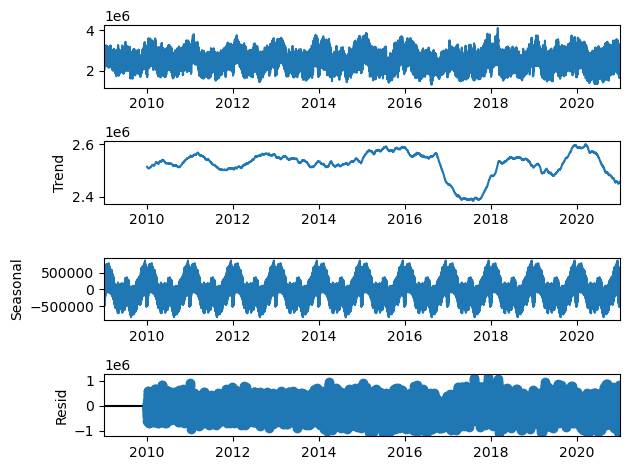

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


analysis = data_4h[['Stromverbrauch Schweiz']].copy()


decompose_result_verbrauch = seasonal_decompose(analysis, model="additive", period=6*365, two_sided=False)


decompose_result_verbrauch.plot()
plt.show()

Dies sieht schon sehr gut aus! Man kann anhand der Grösse der Amplitude der Seasonalität und des Trends sehen, dass die Aufteilung erfolgreich war. Schauen wir uns nun das Budget an.

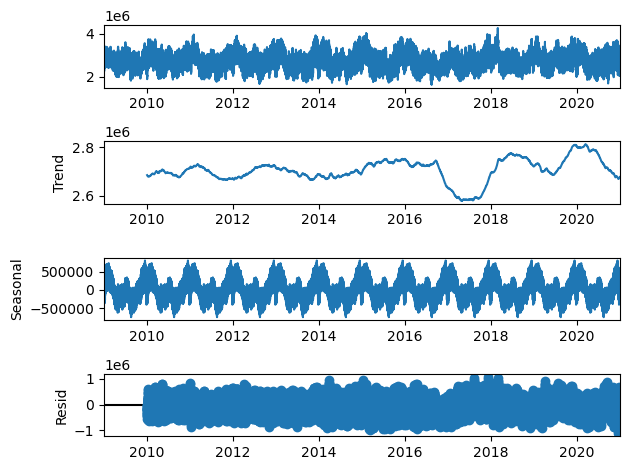

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose


analysis = data_4h[['Strombudget Schweiz']].copy()


decompose_result_budget = seasonal_decompose(analysis, model="additive", period=6*365, two_sided=False)

decompose_result_budget.plot()
plt.show()

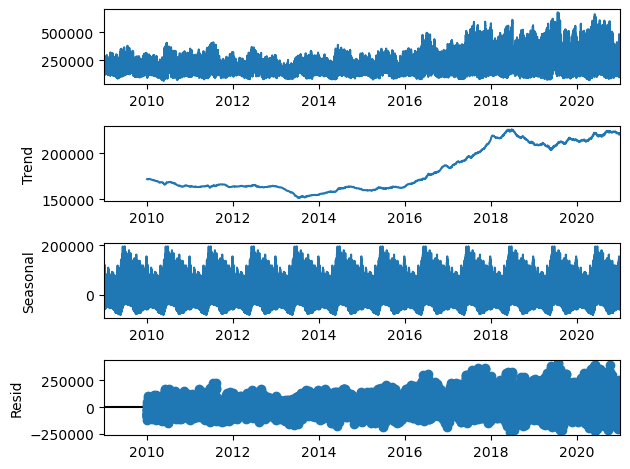

In [27]:
analysis = data_4h[['Strombilanz Schweiz']].copy()


decompose_result_balance = seasonal_decompose(analysis, model="additive", period=6*365, two_sided=False)

decompose_result_balance.plot()
plt.show()

Diese beiden sehen sehr ähnlich aus. Was passiert, wenn man die beiden Trends voneinander abzieht?

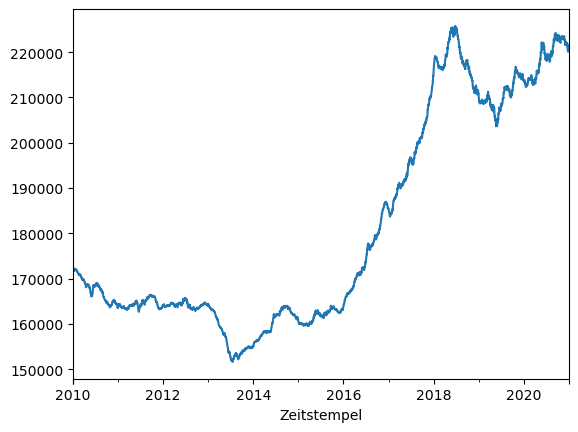

In [28]:
decompose_result_balance = (decompose_result_budget.trend - decompose_result_verbrauch.trend).dropna()
decompose_result_balance.plot.line()
plt.show()

Wir sehen, dass das Budget im Allgemeinen zunimmt. Im Zeitraum von 2013-2015 finden sich viele Artikel über die Gefahr eines grossflächigen Stromausfalls. Ob es da einen Zusammenhang gibt? 

#### Vorhersage des Verbrauchs
Eine Vorhersage des Verbrauchs kann man durch eine Lineare Regressions des Trends erzeugen. Wir können es aber auch einfach machen und den Durchschnitt des Trends nehmen. Die Seasonalität nehmen wir als Grundbaustein. Um die Verteilung der Residuen zu erkennen, nehmen wir den QQ-Plot zur verfügung.

Best dist: norm


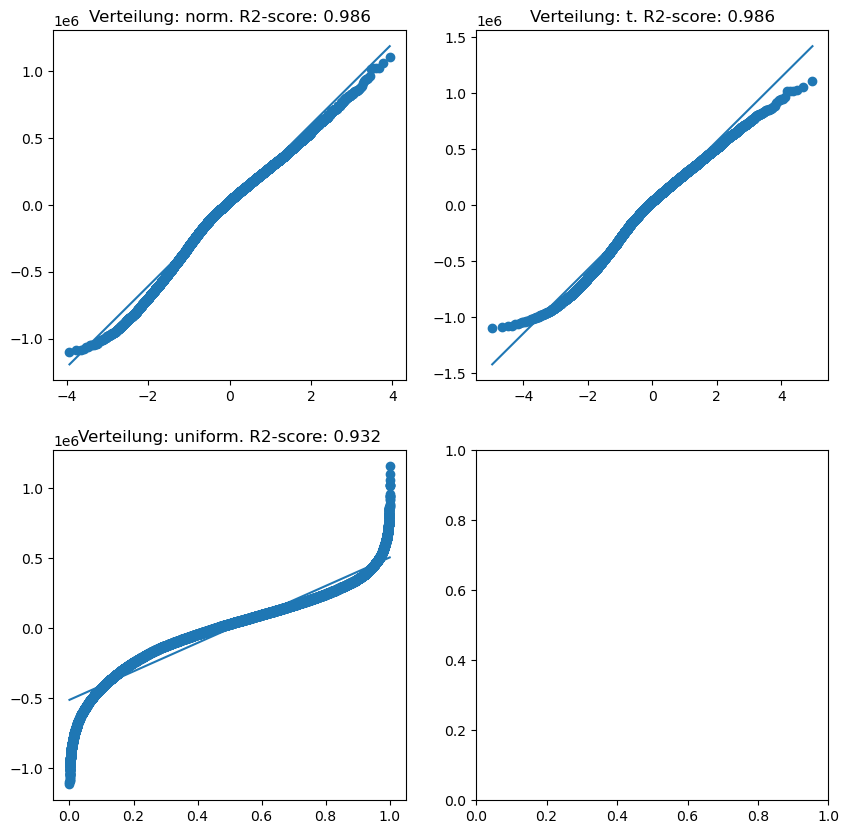

In [29]:
VERTEILUNGEN = [stats.norm, stats.uniform, stats.t]
easy_qq(VERTEILUNGEN, decompose_result_verbrauch.resid.dropna())
plt.show()

Die beste Verteilung ist also die Normalverteilung.
# FFT einbauen

In [33]:
# Brechnung des Means und des Stds:
norm_dist = stats.norm
mean, std = norm_dist.fit(decompose_result_verbrauch.resid.dropna())
print(f'Mean: {mean}. Std: {std}')
norm_dist.rvs(size=1, loc=mean, scale=std)

Mean: -2042.4099749168565. Std: 304318.1373240541


array([330628.53538123])

In [34]:
# Erstellung Prediction ohne Noise:
prediction = decompose_result_verbrauch.seasonal.copy() + decompose_result_verbrauch.trend.mean()
prediction.index = prediction.index + pd.Timedelta('1Y')

C:\Users\vince\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


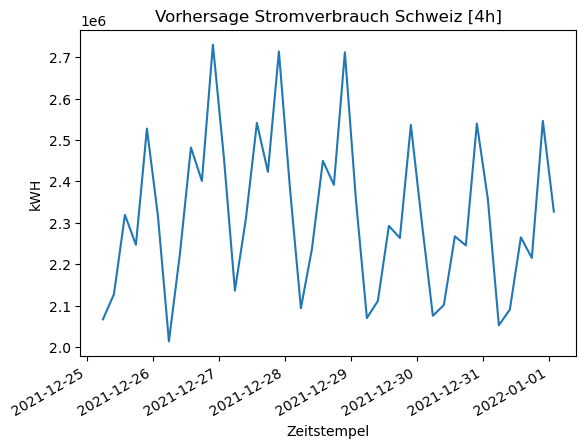

In [36]:
prediction.tail(7*6).plot.line(ylabel='kWH', title='Vorhersage Stromverbrauch Schweiz [4h]')
plt.show()

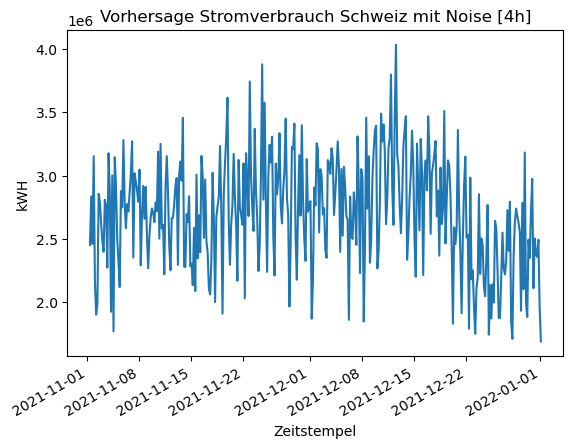

In [65]:
prediction_noise = decompose_result_verbrauch.trend.mean() + prediction + norm_dist.rvs(size=len(prediction), loc=mean, scale=std)
prediction_noise.tail(365).plot.line(ylabel='kWH', title='Vorhersage Stromverbrauch Schweiz mit Noise [4h]')
plt.show()

#### Prediction des Trends
Wir können mithilfe der Linearen Regression auch den Trend vorhersagen, anstatt nur den Mean zu nehmen.


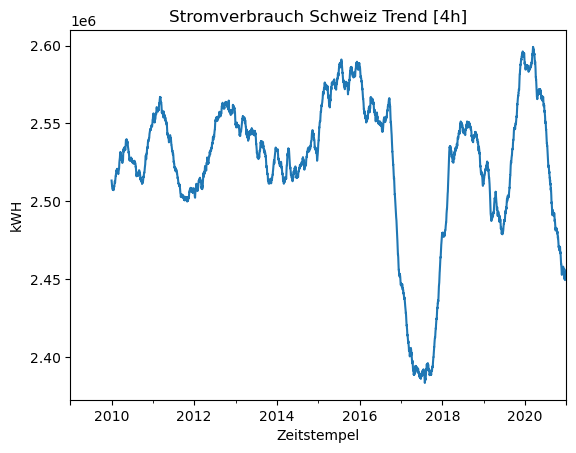

In [78]:
decompose_result_verbrauch.trend.plot.line(ylabel='kWH', title='Stromverbrauch Schweiz Trend [4h]')
plt.show()

### Extremwertanalyse Stromverbrauch Schweiz

In [33]:
# Bei trend lineares modell. Glatte Komponente (Trend <-> Glatte Komponente. Trend noch auseinander nehmen. Arima Forcast vs. eigene Forcast (siehe nächste Zeilen))
# 1. Baseline lineares modell
# 2. Wirtschaftskrise 2022
# Prognose auf Tag
# Arima auf Komponenten und alles und vergleichen mit Decompose.
# Forcast generieren aus Trend prediction + season + resid.
# Forecast with seasonal decomposition?

Zeitstempel
2009-01-01   NaN
2009-01-02   NaN
2009-01-03   NaN
2009-01-04   NaN
2009-01-05   NaN
              ..
2021-12-06   NaN
2021-12-07   NaN
2021-12-08   NaN
2021-12-09   NaN
2021-12-10   NaN
Name: resid, Length: 364, dtype: float64

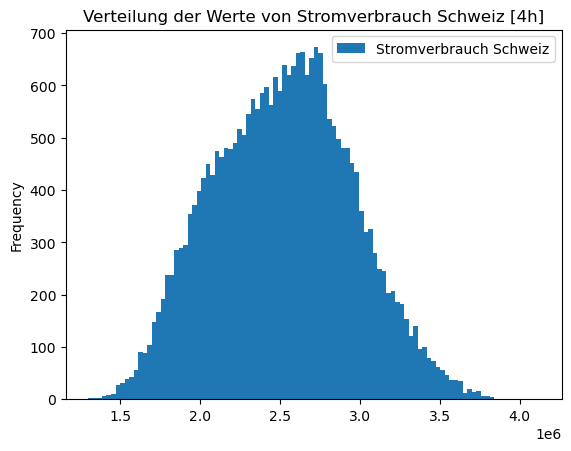

In [39]:
data_4h[['Stromverbrauch Schweiz']].copy().plot.hist(bins=100, title='Verteilung der Werte von Stromverbrauch Schweiz [4h]')
plt.show()

Es sieht Rechtsschief aus.

In [40]:
stats.skew(data_4h[['Stromverbrauch Schweiz']].values.flatten())

0.07181333194032527

Das sagt ebenfalls die Skewness aus. Dies können wir mit einer geeigneten transformation verbessern. Da es Rechtsschief ist, müssen wir die Wurzel ziehen. Durch testen haben wir den Wert 1/1.219 gefunden.

In [43]:
FIX_SWEW_POW_FACTOR =  (1/1.21)
data_4h['Stromverbrauch Schweiz ohne Skewness'] = np.power(data_4h[['Stromverbrauch Schweiz']].values.flatten(), FIX_SWEW_POW_FACTOR)

In [44]:
stats.skew(data_4h['Stromverbrauch Schweiz ohne Skewness'].values.flatten())

0.002497466320287132

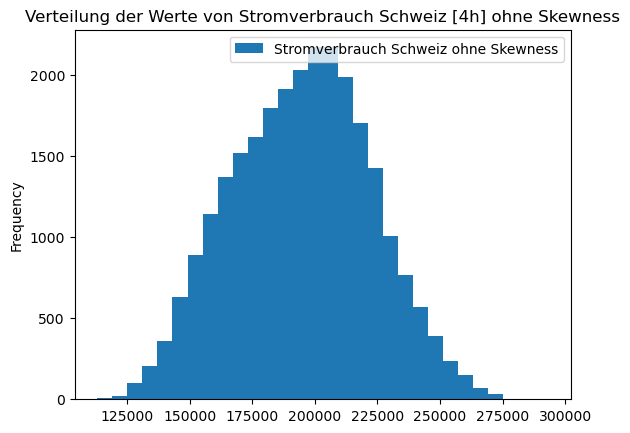

In [45]:
data_4h[['Stromverbrauch Schweiz ohne Skewness']].plot.hist(bins=30, title='Verteilung der Werte von Stromverbrauch Schweiz [4h] ohne Skewness')
plt.show()

In [46]:
# Create list of distributions to check for (from https://www.acsu.buffalo.edu/~adamcunn/probability/probability.html)
dists = [stats.binom, stats.pareto, stats.cauchy, stats.norm, stats.lognorm, stats.t]

#GEV-verteilungen, pareto-verteilung, pareto nur auf extremwerte (~10%)

# Produktionsfunktion ändern auf 70% Allgemein und 30% Solar -> Annahme lineare abnahme zwischen sommer und winter. In der nacht wird kein Strom verbraucht.

C:\Users\vince\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Best dist: norm


C:\Users\vince\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


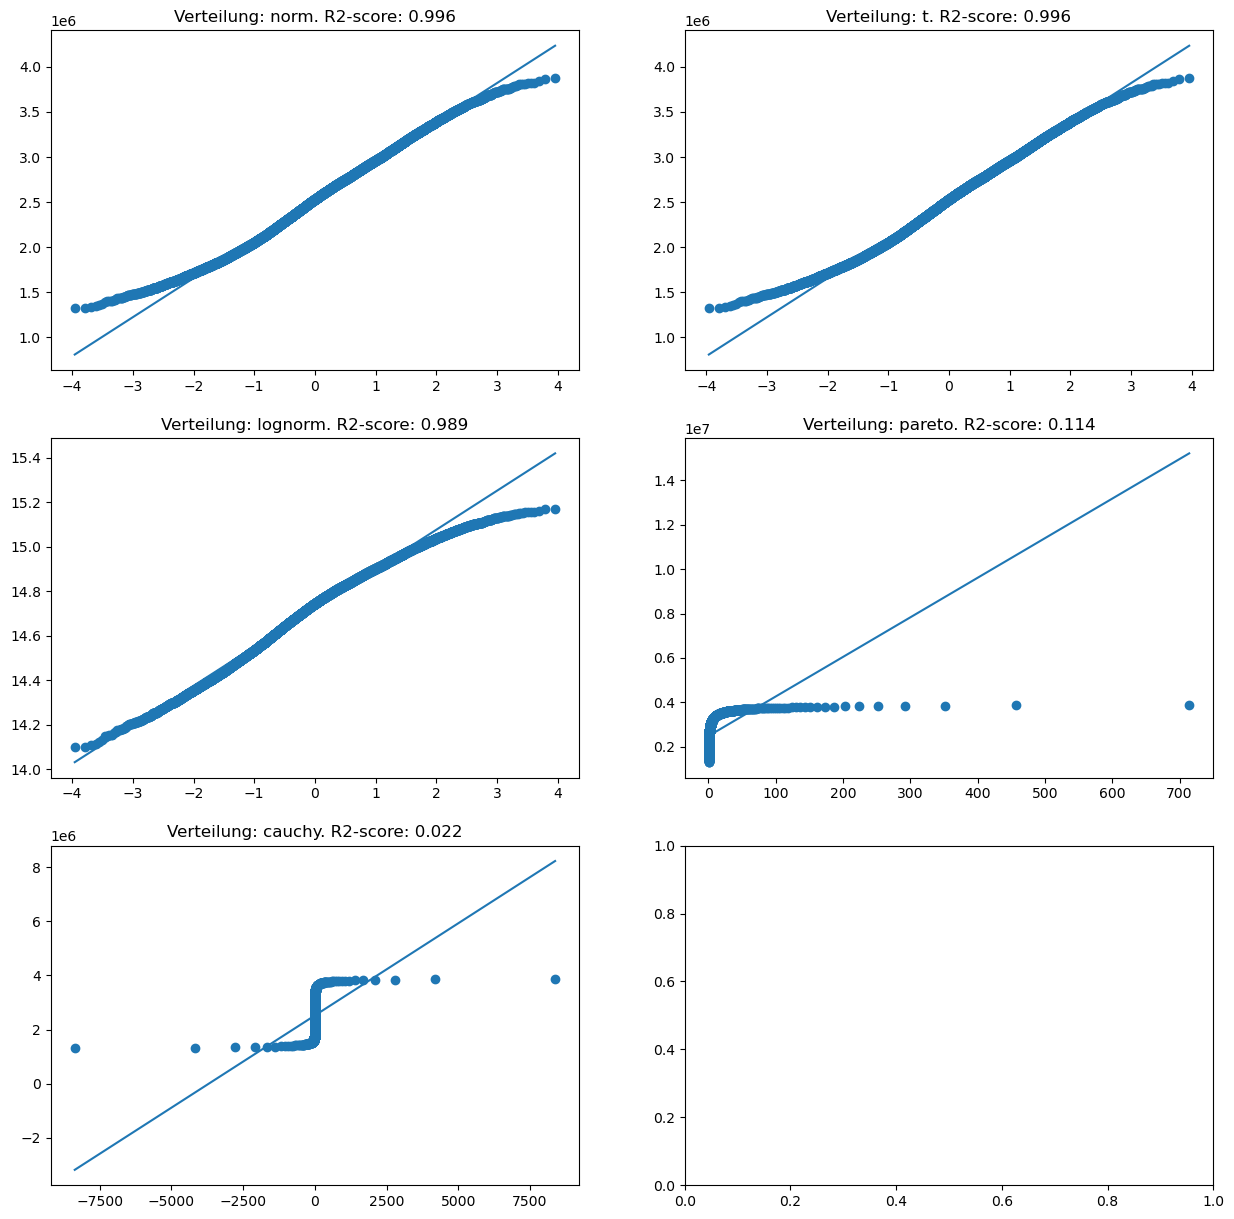

In [66]:
r2_best, best_dist, r2_list, unusable_dist, error_messages = easy_qq(dists, np.sort(data_4h[['Stromverbrauch Schweiz']].values.flatten()))
plt.show()
# t-verteilung wiederkehrtwert/periode, subsample > x, t-verteilung 
# Generalized extremvalue distrubtion GEV, weibull, gumbel, Fréchet

In [67]:
# fit parameters to data
PERCENT_OF_VALUES = 0.9999
distargs = best_dist.fit(data_4h[['Stromverbrauch Schweiz']].values.flatten())

#generate sample with same parameters as input data
sample = best_dist.rvs(*distargs, size = 10000)
sample

array([3334144.50343824, 2661103.63945477, 3168286.74762241, ...,
       2594989.82462668, 2236352.80873226, 2537358.00303911])

In [68]:
f"In {100*PERCENT_OF_VALUES}% of Days the usage will fall between {best_dist.interval(PERCENT_OF_VALUES, *distargs)}. Values outside of this area will happen every {1/(1-PERCENT_OF_VALUES)} Days."

'In 99.99% of Days the usage will fall between (835509.3903698158, 4207633.605435474). Values outside of this area will happen every 10000.0000000011 Days.'

In [69]:
# fit parameters to data
KWH = 5e6
distargs = best_dist.fit(data_4h[['Stromverbrauch Schweiz']].values.flatten())

In [71]:
f"Every {1/(1-best_dist.cdf(KWH, *distargs))} Days we can except to see an usage above {KWH} kWH. It corresponds to a chance of {(1-best_dist.cdf(KWH, *distargs))*100}%."

'Every 186626311.93646201 Days we can except to see an usage above 5000000.0 kWH. It corresponds to a chance of 5.3583012471492e-07%.'

#### Wie oft reicht 10% der Spitzenproduktion nicht aus?
Dafür schauen wir uns die Produktion an und nehmen da das 10te Percentil an. Vom Verbrauch nehmen wir die gefundene Verteilung oben.

In [72]:
spitzenproduktion = data_4h['Strombudget Schweiz'].quantile(q=0.1)

In [73]:
best_dist.cdf(spitzenproduktion, *distargs)

0.22533579487280414

Wir sehen also, dass 10% der Spitzenproduktion gerademal in 22.5% der 4h Stunden Intervalle ausreicht. Somit reicht diese in 77.5% der 4h Intervalle nicht aus.

### Extremwertanalyse Strombilanz Schweiz
Nun schauen wir uns die Extremwerte der Bilanz an.

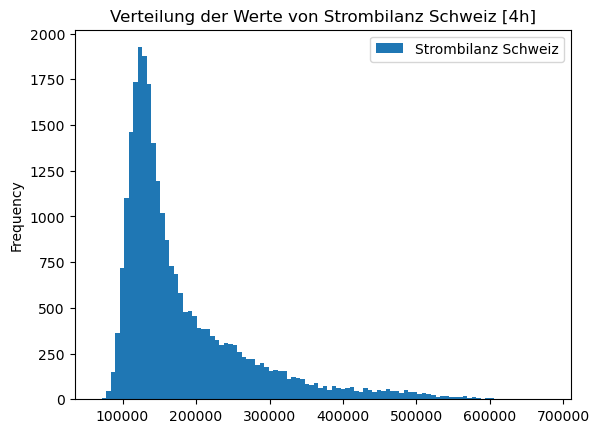

In [107]:
data_4h[['Strombilanz Schweiz']].copy().plot.hist(bins=100, title='Verteilung der Werte von Strombilanz Schweiz [4h]')
plt.show()

Es sieht definitiv logarithmisch aus. Wir schauen uns also Verteilungen an, welche einen Longtail haben.

In [138]:
# Create list of distributions to check for (from https://www.acsu.buffalo.edu/~adamcunn/probability/probability.html)
dists = [stats.pareto, stats.chi2, stats.lognorm, stats.cauchy, stats.gamma, stats.norm, stats.t]

#GEV-verteilungen, pareto-verteilung, pareto nur auf extremwerte (~10%)

# Produktionsfunktion ändern auf 70% Allgemein und 30% Solar -> Annahme lineare abnahme zwischen sommer und winter. In der nacht wird kein Strom verbraucht.

C:\Users\vince\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Best dist: lognorm


C:\Users\vince\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


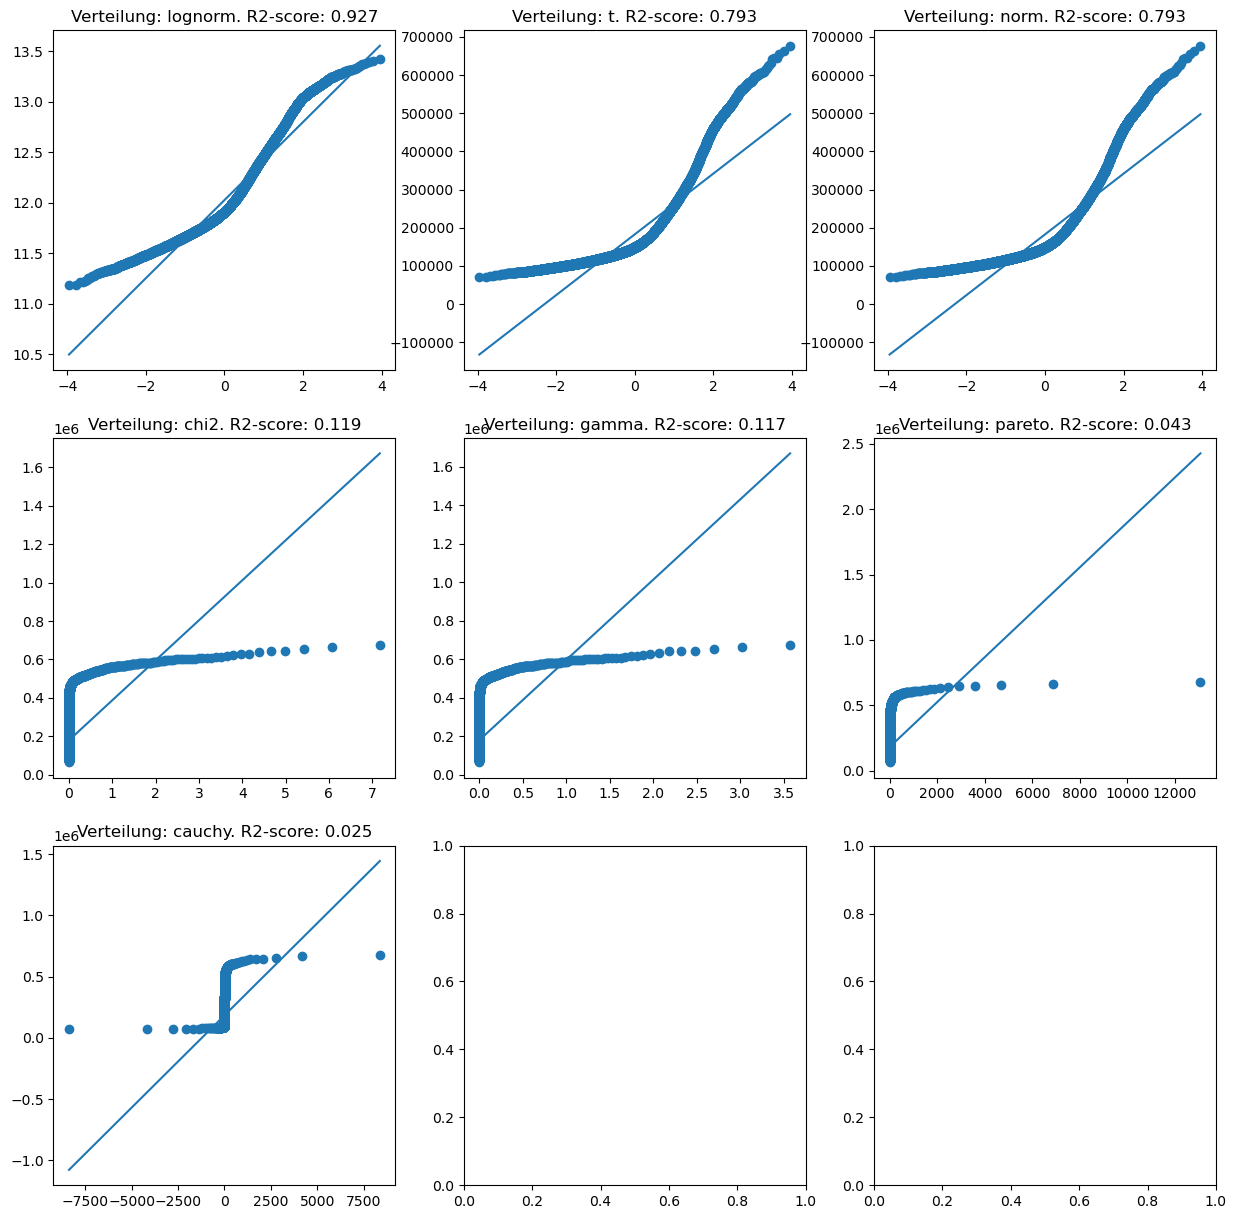

In [139]:
r2_best, best_dist, r2_list, unusable_dist, error_messages = easy_qq(dists, np.sort(data_4h[['Strombilanz Schweiz']].values.flatten()))
plt.show()

Sieht schlecht aus. Vorallem kann mit Lognorm keine negativen Werte schätzen. Wir nehmen also den Log und schauen, was dann passiert.

C:\Users\vince\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Best dist: gamma


C:\Users\vince\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2494: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


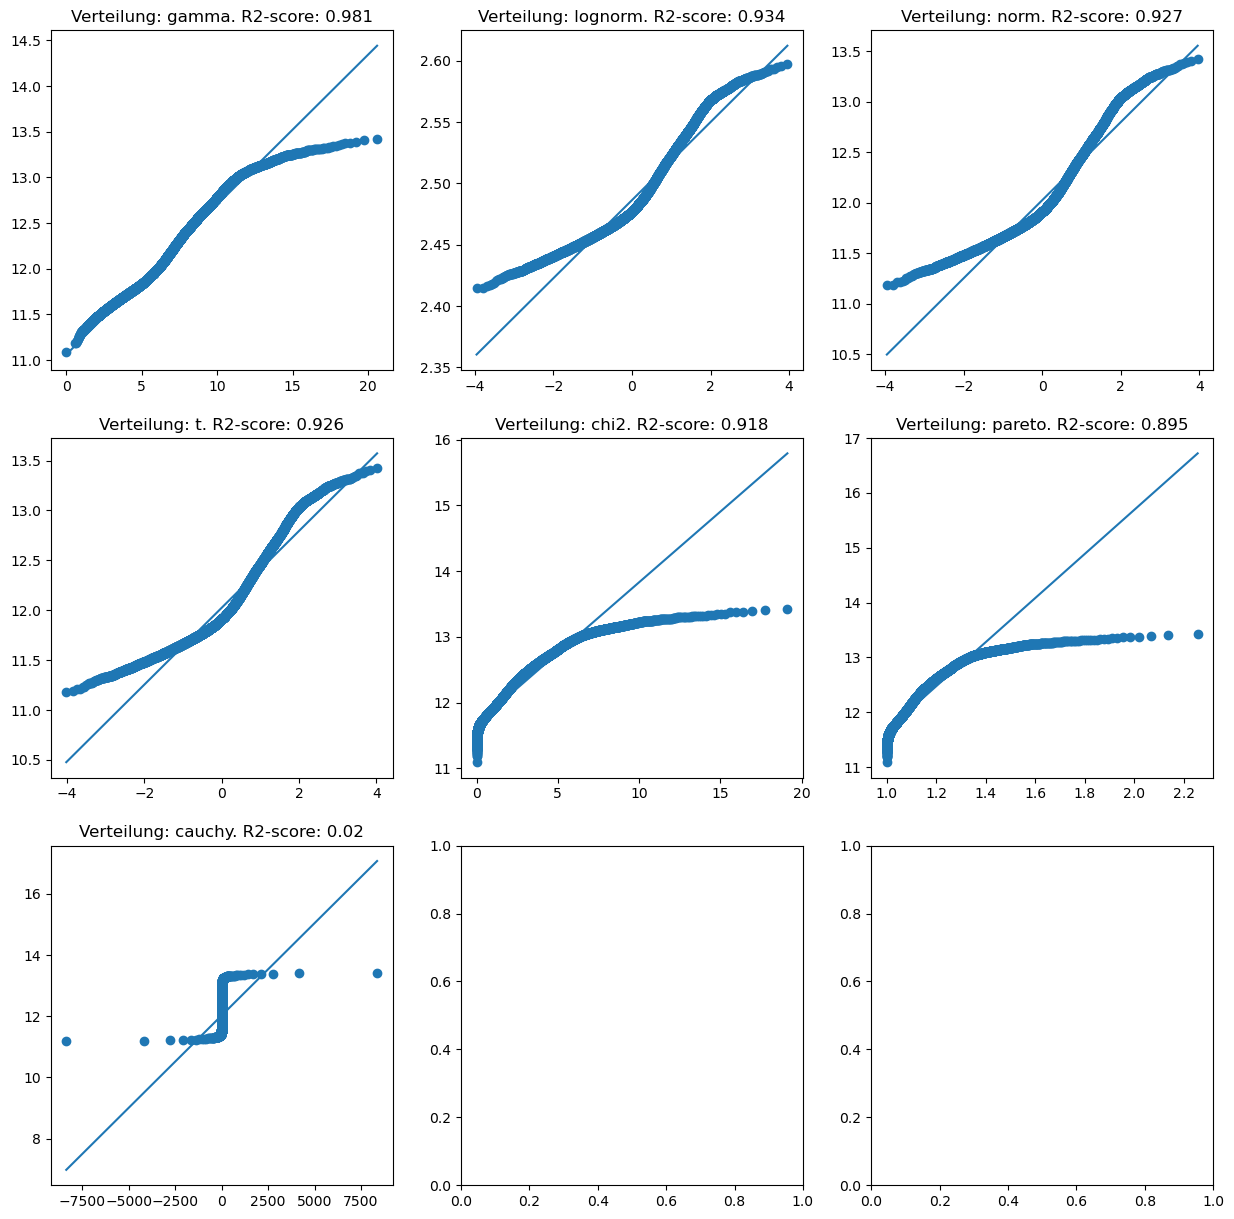

In [152]:
r2_best, best_dist, r2_list, unusable_dist, error_messages = easy_qq(dists, np.log(data_4h[['Strombilanz Schweiz']].values.flatten()))#[50:])
plt.show()

Wir sehen, dass die Verteilungen noch immer eher schlecht sind. Uns interessieren aber hauptsätzlich die tiefen Werte und da ist die Gamma-Verteilung sehr gut! Also, die Log-Gamma Verteilung? 

In [177]:
# fit parameters to data
PERCENT_OF_VALUES = 0.999
distargs = best_dist.fit(np.log(data_4h[['Strombilanz Schweiz']].values.flatten()))

#generate sample with same parameters as input data
sample = np.exp(best_dist.rvs(*distargs, size = 10000))
sample

array([ 99612.31498001, 223344.6136349 , 147263.25570876, ...,
       174463.49952637,  85200.30992249,  98928.23247804])

In [184]:
f"In {100*(PERCENT_OF_VALUES**4)}% of Days the buffer will have between {np.exp(best_dist.interval(PERCENT_OF_VALUES, *distargs))} kMh. Values outside of this area will happen every {1/(1-PERCENT_OF_VALUES**4)} Days."

'In 99.6005996001% of Days the buffer will have between [  75837.42665957 1012160.26767539] kMh. Values outside of this area will happen every 250.37531265626794 Days.'

In [176]:
KWH = 70000
f"Every {4/best_dist.cdf(np.log(KWH), *distargs)/6} Days we can except to see see the buffer fall below {KWH} kWH. It corresponds to a chance of {(best_dist.cdf(np.log(KWH), *distargs))*100}% per 4h intervall."

'Every 90777.4143875905 Days we can except to see see the buffer fall below 70000 kWH. It corresponds to a chance of 0.000734397064693001% per 4h intervall.'